### Modelo predictivo de demanda de variables

In [10]:
!pip install ydata-profiling
!pip install keras-tuner
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [11]:
import os                          # operating system interfaces
import glob                        # working with OS pathnames
import datetime                      # time processing
import numpy as np                 # linear algebra
import pandas as pd                # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt    # data visualization purposes
import seaborn as sns              # statistical data visualization
sns.set_theme()

# Display function to clear notebook cell's output.
from IPython.display import clear_output

# Deepcopy to store object's values instead of references.
from copy import deepcopy

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, Flatten
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
## import keras_tuner as kt

# Set seed to make Python, NumPy, and TensorFlow deterministic.
tf.keras.utils.set_random_seed(27)
from ydata_profiling import ProfileReport

import keras_tuner as kt

In [30]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_excel('gdrive/My Drive/Analitica/Proyecto 1/SeoulBikeData_utf8 limpiado.xlsx') # Remove index_col=0

# 1. Convertir la columna 'Date' al formato datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,1,False,False,True
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,1,False,False,True
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,1,False,False,True
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,1,False,False,True
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,1,False,False,True


In [31]:
df.shape

(8760, 16)

In [32]:
print(df.isnull().sum())


Date                        0
Rented Bike Count           0
Hour                        0
Temperature(C)              0
Humidity(%)                 0
Wind speed (m/s)            0
Visibility (10m)            0
Dew point temperature(C)    0
Solar Radiation (MJ/m2)     0
Rainfall(mm)                0
Snowfall (cm)               0
Holiday                     0
Functioning Day             0
Seasons_Spring              0
Seasons_Summer              0
Seasons_Winter              0
dtype: int64


In [33]:
df.dropna(inplace=True)

In [34]:
df.shape

(8760, 16)

In [35]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      8760 non-null   datetime64[ns]
 1   Rented Bike Count         8760 non-null   int64         
 2   Hour                      8760 non-null   int64         
 3   Temperature(C)            8760 non-null   float64       
 4   Humidity(%)               8760 non-null   int64         
 5   Wind speed (m/s)          8760 non-null   float64       
 6   Visibility (10m)          8760 non-null   int64         
 7   Dew point temperature(C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)   8760 non-null   float64       
 9   Rainfall(mm)              8760 non-null   float64       
 10  Snowfall (cm)             8760 non-null   float64       
 11  Holiday                   8760 non-null   int64         
 12  Functioning Day     

In [36]:
ProfileReport(df)

Output hidden; open in https://colab.research.google.com to view.

In [39]:
df.dtypes

,0
Date,datetime64[ns]
Rented Bike Count,float64
Hour,float64
Temperature(C),float64
Humidity(%),float64
Wind speed (m/s),float64
Visibility (10m),float64
Dew point temperature(C),float64
Solar Radiation (MJ/m2),float64
Rainfall(mm),float64


In [38]:

# Select columns to convert to float
numeric_cols = df.select_dtypes(include=['number']).columns

# Convert selected columns to float
df_nuevo=df[numeric_cols] = df[numeric_cols].astype(float)

# Check data types
print(df_nuevo.dtypes)


Rented Bike Count           float64
Hour                        float64
Temperature(C)              float64
Humidity(%)                 float64
Wind speed (m/s)            float64
Visibility (10m)            float64
Dew point temperature(C)    float64
Solar Radiation (MJ/m2)     float64
Rainfall(mm)                float64
Snowfall (cm)               float64
Holiday                     float64
Functioning Day             float64
dtype: object


In [40]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,2017-12-01,254.0,0.0,-5.2,37.0,2.2,2000.0,-17.6,0.0,0.0,0.0,0.0,1.0,False,False,True
1,2017-12-01,204.0,1.0,-5.5,38.0,0.8,2000.0,-17.6,0.0,0.0,0.0,0.0,1.0,False,False,True
2,2017-12-01,173.0,2.0,-6.0,39.0,1.0,2000.0,-17.7,0.0,0.0,0.0,0.0,1.0,False,False,True
3,2017-12-01,107.0,3.0,-6.2,40.0,0.9,2000.0,-17.6,0.0,0.0,0.0,0.0,1.0,False,False,True
4,2017-12-01,78.0,4.0,-6.0,36.0,2.3,2000.0,-18.6,0.0,0.0,0.0,0.0,1.0,False,False,True


In [71]:


# Select columns to convert to float
boolean_cols = df.select_dtypes(include=['bool']).columns

# Convert selected columns to float
df[boolean_cols] = df[boolean_cols].astype(float)

# Check data types
print(df.dtypes)


Date                        float64
Rented Bike Count           float64
Hour                        float64
Temperature(C)              float64
Humidity(%)                 float64
Wind speed (m/s)            float64
Visibility (10m)            float64
Dew point temperature(C)    float64
Solar Radiation (MJ/m2)     float64
Rainfall(mm)                float64
Snowfall (cm)               float64
Holiday                     float64
Functioning Day             float64
Seasons_Spring              float64
Seasons_Summer              float64
Seasons_Winter              float64
dtype: object


In [69]:
# prompt: pasame tambien la variable Date de datetime64 a float no a int

import pandas as pd
import numpy as np
# Convert 'Date' column to numerical values (float)
df['Date'] = pd.to_datetime(df['Date']).astype(np.int64) / 10**9  # Convert to seconds since epoch


In [70]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,1.512086e+09,254.0,0.0,-5.2,37.0,2.2,2000.0,-17.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.512086e+09,204.0,1.0,-5.5,38.0,0.8,2000.0,-17.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.512086e+09,173.0,2.0,-6.0,39.0,1.0,2000.0,-17.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.512086e+09,107.0,3.0,-6.2,40.0,0.9,2000.0,-17.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.512086e+09,78.0,4.0,-6.0,36.0,2.3,2000.0,-18.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [73]:
val_df = 0.2
test_df = 0.1
n = len(df)

train_df = df[0:int(n*(1-val_df))]
val_df = df[int(n*(1-(val_df+test_df))):int(n*(1-test_df))]
test_df = df[int(n*(1-test_df)):]

# Normalización

In [122]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<ipython-input-124-4ec9be458a7e>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


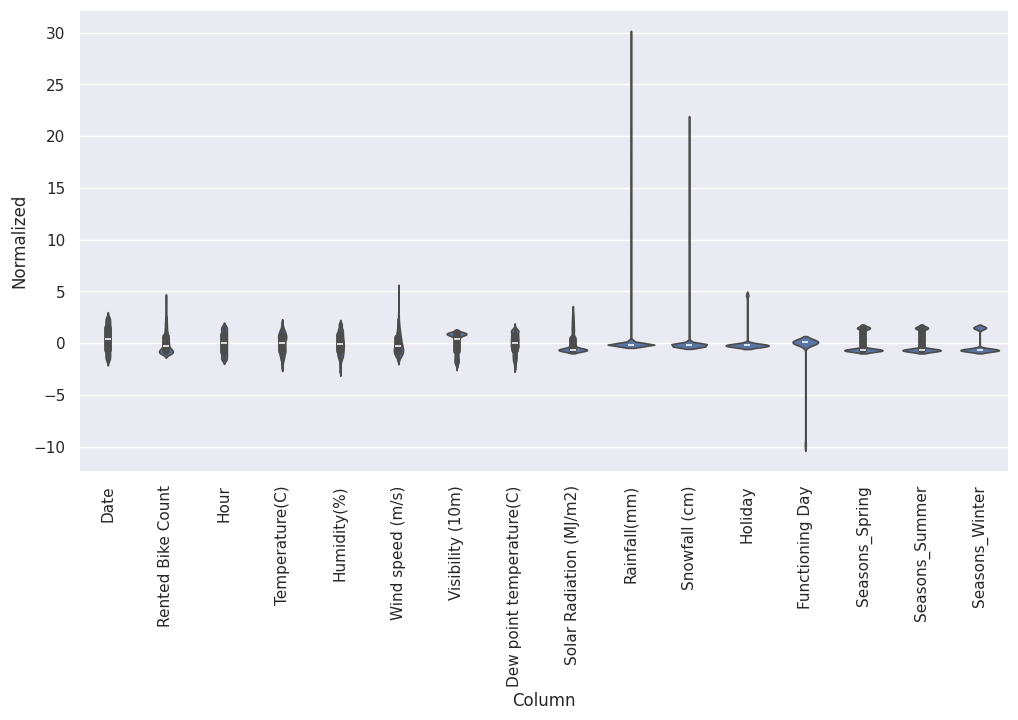

In [124]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [125]:
def denormalize(data):
    return (data * train_std) + train_mean

# Creacion de seres de tiempo

In [126]:
DATETIME_FEATURES = ['Date']

In [127]:
class WindowGenerator():
    def __init__(self, input_width, label_width, label_columns, offset, train_df=train_df, val_df=val_df, test_df=test_df):

        # Store the raw data.
        self.train_df = train_df[label_columns + DATETIME_FEATURES]
        self.val_df = val_df[label_columns + DATETIME_FEATURES]
        self.test_df = test_df[label_columns + DATETIME_FEATURES]

        # Work out the label column indices.
        self.column_indices = {name: i for i, name in enumerate(self.train_df.columns)}
        self.label_columns = label_columns
        self.label_columns_indices = [self.column_indices[feature] for feature in self.label_columns]

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.offset = offset
        self.window_size = self.input_width + self.offset

        # Work out input and label indices.
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.window_size)[self.input_slice]

        self.label_start = self.window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.window_size)[self.label_slice]

        # Initialize the splitted train, val, and test datasets for easy use.
        self._initialize_sets()

    def _initialize_sets(self):
        self._train = self.split_window(self.train_df)
        self._val = self.split_window(self.val_df)
        self._test = self.split_window(self.test_df)

    def __repr__(self):
        return '\n'.join([f'Total window size: {self.window_size}',
                          f'Input indices: {self.input_indices}',
                          f'Label indices: {self.label_indices}',
                          f'Target features: {self.label_columns}'])

In [128]:
def split_window(self, data):

    np_df = np.array(data)
    inputs = []
    labels = []

    for i in range(len(np_df) - self.window_size):
        current_window = np_df[i:i+self.window_size]
        inputs.append(current_window[self.input_slice])
        labels.append(current_window[self.label_slice, self.label_columns_indices])
    return np.array(inputs), np.array(labels)

WindowGenerator.split_window = split_window

In [129]:
@property
def train(self):
    return self._train
@property
def val(self):
    return self._val
@property
def test(self):
    return self._test

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [130]:
@property
def data_shapes(self):

    print('\n'.join([f'Train:\t {self._train[0].shape} | {self._train[1].shape}',
                     f'Val:\t {self._val[0].shape} | {self._val[1].shape}',
                     f'Test:\t {self._test[0].shape} | {self._test[1].shape}']))

WindowGenerator.data_shapes = data_shapes

In [131]:
@property
def get_model_params(self):

    # Shape of training X vectors is [batch, time, num_layer_units]
    n_steps = self.train[0].shape[1]

    # Shape of input features is [observation, features]
    n_features = self.train_df.shape[1]

    # Shape of target y vector is [batch, time, outputs]
    n_outputs = self.train[1].shape[-1]

    print('\n'.join([f'Number of time steps: {n_steps}',
                     f'Number of input features: {n_features}',
                     f'Number of output features: {n_outputs}']))

    return n_steps, n_features, n_outputs

WindowGenerator.get_model_params = get_model_params

In [132]:
single_step_window = WindowGenerator(input_width=24, label_width=1, offset=1, label_columns=['Rented Bike Count'])
single_step_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Target features: ['Rented Bike Count']

In [133]:
single_step_window.data_shapes

Train:	 (6983, 24, 2) | (6983, 1, 1)
Val:	 (1727, 24, 2) | (1727, 1, 1)
Test:	 (851, 24, 2) | (851, 1, 1)


In [134]:
n_steps, n_features, n_outputs = single_step_window.get_model_params

Number of time steps: 24
Number of input features: 2
Number of output features: 1


### Modelo de Paso Único

#### Red Neuronal Recurrente

Se utilizará una Red Neuronal Recurrente específica llamada Memoria a Largo Corto Plazo (LSTM), adecuada para predicciones en series temporales univariadas. Los modelos LSTM se entrenan con datos históricos para predecir el siguiente valor en la secuencia. Una de las variaciones del modelo es el LSTM Vanilla, que consiste en una sola capa oculta de unidades LSTM y una capa de salida para hacer predicciones.

In [135]:
lstm_vanilla = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(32),
    Dense(n_outputs, activation='linear')
])

### Modelo Apilado

Un LSTM apilado (Stacked LSTM) es un modelo que consta de múltiples capas LSTM. En esta funcion, cada capa LSTM proporciona una secuencia de salida a la capa LSTM inferior, con una salida por cada paso de tiempo de entrada. Apilar múltiples capas LSTM permite al modelo capturar patrones de dependencia temporal más complejos. Los LSTM apilados se utilizan a menudo en tareas de pronóstico de series temporales para capturar patrones complejos en los datos.

In [136]:
lstm_stacked = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(n_outputs, activation='linear')
])

### Modelo Bidireccionale (Bidirectional)

Un LSTM bidireccional es un modelo que permite que la información fluya tanto hacia adelante como hacia atrás en la secuencia. En un LSTM estándar, la información fluye solo en una dirección, del pasado al futuro. En cambio, en un LSTM bidireccional, la secuencia de entrada se divide en dos partes: una se procesa en dirección hacia adelante y la otra en dirección inversa.

Las salidas de ambas direcciones se combinan, típicamente por concatenación, para formar la secuencia de salida final. Esto se logra duplicando la capa oculta del LSTM y procesando la secuencia de entrada en ambas direcciones. Esto permite al modelo capturar patrones que pueden depender tanto de las observaciones futuras como de las pasadas.

In [137]:
lstm_bi = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    Bidirectional(LSTM(32)),
    Dense(n_outputs, activation='linear')
])

## Modelo Apilado Bidireccional

Un LSTM apilado bidireccional combina los conceptos de LSTMs apilados y bidireccionales. Consiste en múltiples capas LSTM, donde cada capa procesa la secuencia de entrada en ambas direcciones, hacia adelante y hacia atrás. Esto permite al modelo capturar dependencias temporales complejas al considerar tanto el contexto pasado como el futuro.

En un LSTM apilado bidireccional, la secuencia de salida de una capa LSTM se utiliza como entrada para la siguiente capa LSTM, similar a un LSTM apilado. Sin embargo, cada capa LSTM en este modelo es bidireccional, lo que significa que procesa la secuencia de entrada en ambas direcciones. Las salidas de todas las capas LSTM se combinan para formar la secuencia de salida final.

In [138]:
lstm_stacked_bi = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(n_outputs, activation='linear')
])

### Modelos Apilados Bidireccionales

Un LSTM apilado bidireccional combina los conceptos de LSTMs apilados y bidireccionales. Consiste en múltiples capas LSTM, donde cada capa procesa la secuencia de entrada en ambas direcciones, hacia adelante y hacia atrás. Esto permite al modelo capturar dependencias temporales complejas al considerar tanto el contexto pasado como el futuro.

En un LSTM apilado bidireccional, la secuencia de salida de una capa LSTM se utiliza como entrada para la siguiente capa LSTM, similar a un LSTM apilado. Sin embargo, cada capa LSTM en este modelo es bidireccional, lo que significa que procesa la secuencia de entrada en ambas direcciones. Las salidas de todas las capas LSTM se combinan para formar la secuencia de salida final.

In [139]:
cnn_1d = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    Conv1D(filters=32, kernel_size=(n_steps), activation='relu'),
    Flatten(),
    Dense(n_outputs, activation='linear')
])

### Modelos CNN-LSTM

La arquitectura de redes convolucionales unidimensionales (1D CNN) combinada con LSTM es un tipo de red neuronal utilizada para la predicción de series temporales. Esta combinación aprovecha las fortalezas de las redes neuronales convolucionales (CNNs) y las redes de memoria a largo corto plazo (LSTM) para capturar dependencias temporales tanto locales como globales en los datos.

In [140]:
cnn_lstm = tf.keras.Sequential([
    Input(shape=(n_steps, n_features)),
    Conv1D(filters=32, kernel_size=(n_steps), activation='relu'),
    LSTM(32),
    Dense(n_outputs, activation='linear')
])

Entrenamiento del modelo

In [141]:
epocas = 30
PATIENCE = 2
metrica = 'mean_absolute_error'

In [142]:
models = {
    "vanilla": lstm_vanilla,
    "stacked":  lstm_stacked,
    "bidirectional": lstm_bi,
    "bidirectional_stacked": lstm_stacked_bi,
    "cnn_1d": cnn_1d,
    "cnn_lstm": cnn_lstm
}

In [143]:
def compile_and_fit(model, window, patience=PATIENCE, num_epochs=epocas):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=PATIENCE,
                                                      mode='min',
                                                      restore_best_weights=True,
                                                      start_from_epoch=5)

    model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = MeanSquaredError(),
                  metrics = [MeanAbsoluteError()])

    history = model.fit(window.train[0], window.train[1],
                        validation_data=window.val,
                        epochs=epocas,
                        callbacks=[early_stopping])

    return history

In [144]:
histories = {}

for model_arch, model in models.items():
    clear_output(wait=False)
    print(f'Training [{model_arch}] model architecture...')
    histories[model_arch] = compile_and_fit(model, single_step_window)

Training [cnn_lstm] model architecture...
Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5315 - mean_absolute_error: 0.5008 - val_loss: 0.2437 - val_mean_absolute_error: 0.3432
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1291 - mean_absolute_error: 0.2321 - val_loss: 0.1369 - val_mean_absolute_error: 0.2640
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0821 - mean_absolute_error: 0.1837 - val_loss: 0.1141 - val_mean_absolute_error: 0.2474
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0663 - mean_absolute_error: 0.1630 - val_loss: 0.1028 - val_mean_absolute_error: 0.2391
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0590 - mean_absolute_error: 0.1522 - val_loss: 0.0965 - val_mean_absolute_error: 0.2326
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0547 - mean_absolute_error: 0.1453 - val_loss: 0.0928 - val_mean_absolute_error: 0.2277
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

In [145]:
def plot_errors(histories):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for model_arch, history in histories.items():
        axes[0].plot(history.history[metrica], label=model_arch)
        axes[1].plot(history.history[f'val_{metrica}'], label=model_arch)

    axes[0].set_title(metrica)
    axes[1].set_title(f'Validation {metrica}')

    axes[0].legend()
    axes[1].legend()

    plt.show()

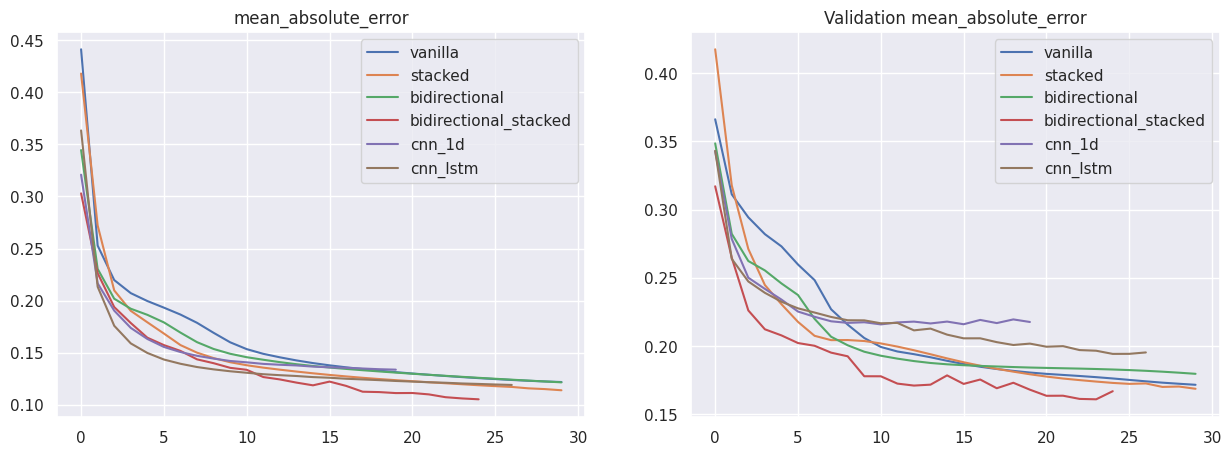

In [146]:
plot_errors(histories)

In [147]:
best_scores = []

for model_arch, history in histories.items():
    best_scores.append([model_arch,
                        min(history.history['val_loss']),
                        min(history.history[f'val_{metrica}'])])

In [148]:
best_scores = pd.DataFrame(best_scores, columns =['Architecture', 'validation_MSE', 'validation_MAE']) # Removed 'mean_absolute_error' from columns
best_scores = best_scores.set_index('Architecture')
best_scores.sort_values(by=['validation_MAE'])

,validation_MSE,validation_MAE
Architecture,,
bidirectional_stacked,0.064041,0.161072
stacked,0.067463,0.168788
vanilla,0.072840,0.171705
bidirectional,0.071867,0.179747
cnn_lstm,0.076733,0.194347
cnn_1d,0.090650,0.215961


In [149]:
val_performance = {}
performance = {}

for model_arch, model in models.items():
    val_performance[model_arch] = model.evaluate(single_step_window.val[0], single_step_window.val[1])
    performance[model_arch] = model.evaluate(single_step_window.test[0], single_step_window.test[1], verbose=0)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0596 - mean_absolute_error: 0.1603
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0586 - mean_absolute_error: 0.1571
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0583 - mean_absolute_error: 0.1635
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0503 - mean_absolute_error: 0.1496
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0730 - mean_absolute_error: 0.1952
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0614 - mean_absolute_error: 0.1741


In [150]:
def denormalize(data, train_std, train_mean):
    # Asegúrate de no incluir el índice en las operaciones de denormalización
    data_denorm = (data * train_std) + train_mean
    return data_denorm


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


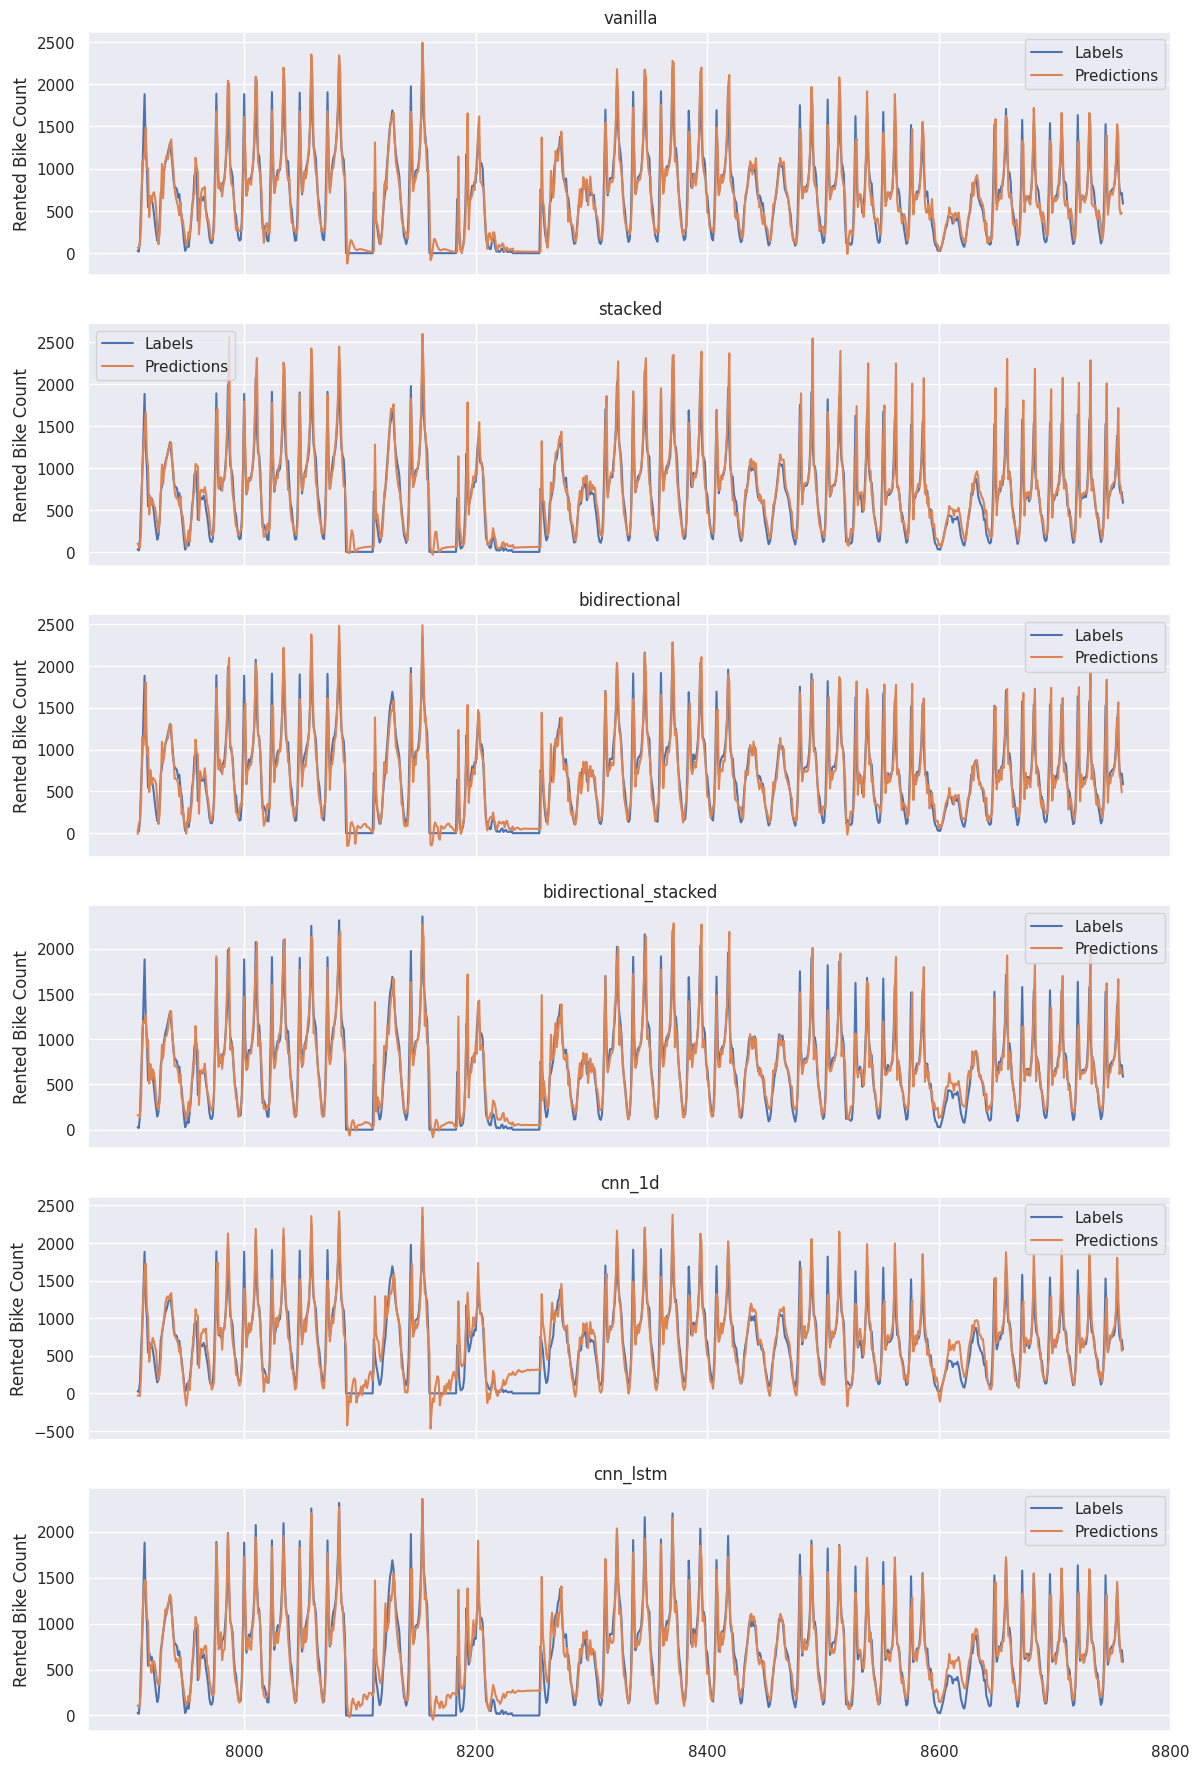

In [151]:
fig, axes = plt.subplots(len(models), 1, figsize=(12, 3*len(models)), sharex=True)
fig.tight_layout(pad=2.0)

for index, (model_name, model) in enumerate(models.items()):
    # Use models to make predictions on the test set
    predictions = model.predict(single_step_window.test[0])
    predictions = pd.DataFrame(predictions, index=test_df.index[single_step_window.input_width:-1], columns=single_step_window.label_columns)

    # Denormalize the records to their actual values
    predictions_denormalized = denormalize(predictions, train_std, train_mean)
    test_df_denormalized = denormalize(test_df, train_std, train_mean)


    # Plot the actual data, as well as the prediction data
    sns.lineplot(data=test_df_denormalized[24:], x=test_df_denormalized.index[24:], y=single_step_window.label_columns[0], label="Labels", ax=axes[index])
    sns.lineplot(data=predictions_denormalized, x=predictions_denormalized.index, y=single_step_window.label_columns[0], label="Predictions", ax=axes[index])
    axes[index].set_title(model_name)
    axes[index].set(xlabel=None)

plt.show()

### Ingresos

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


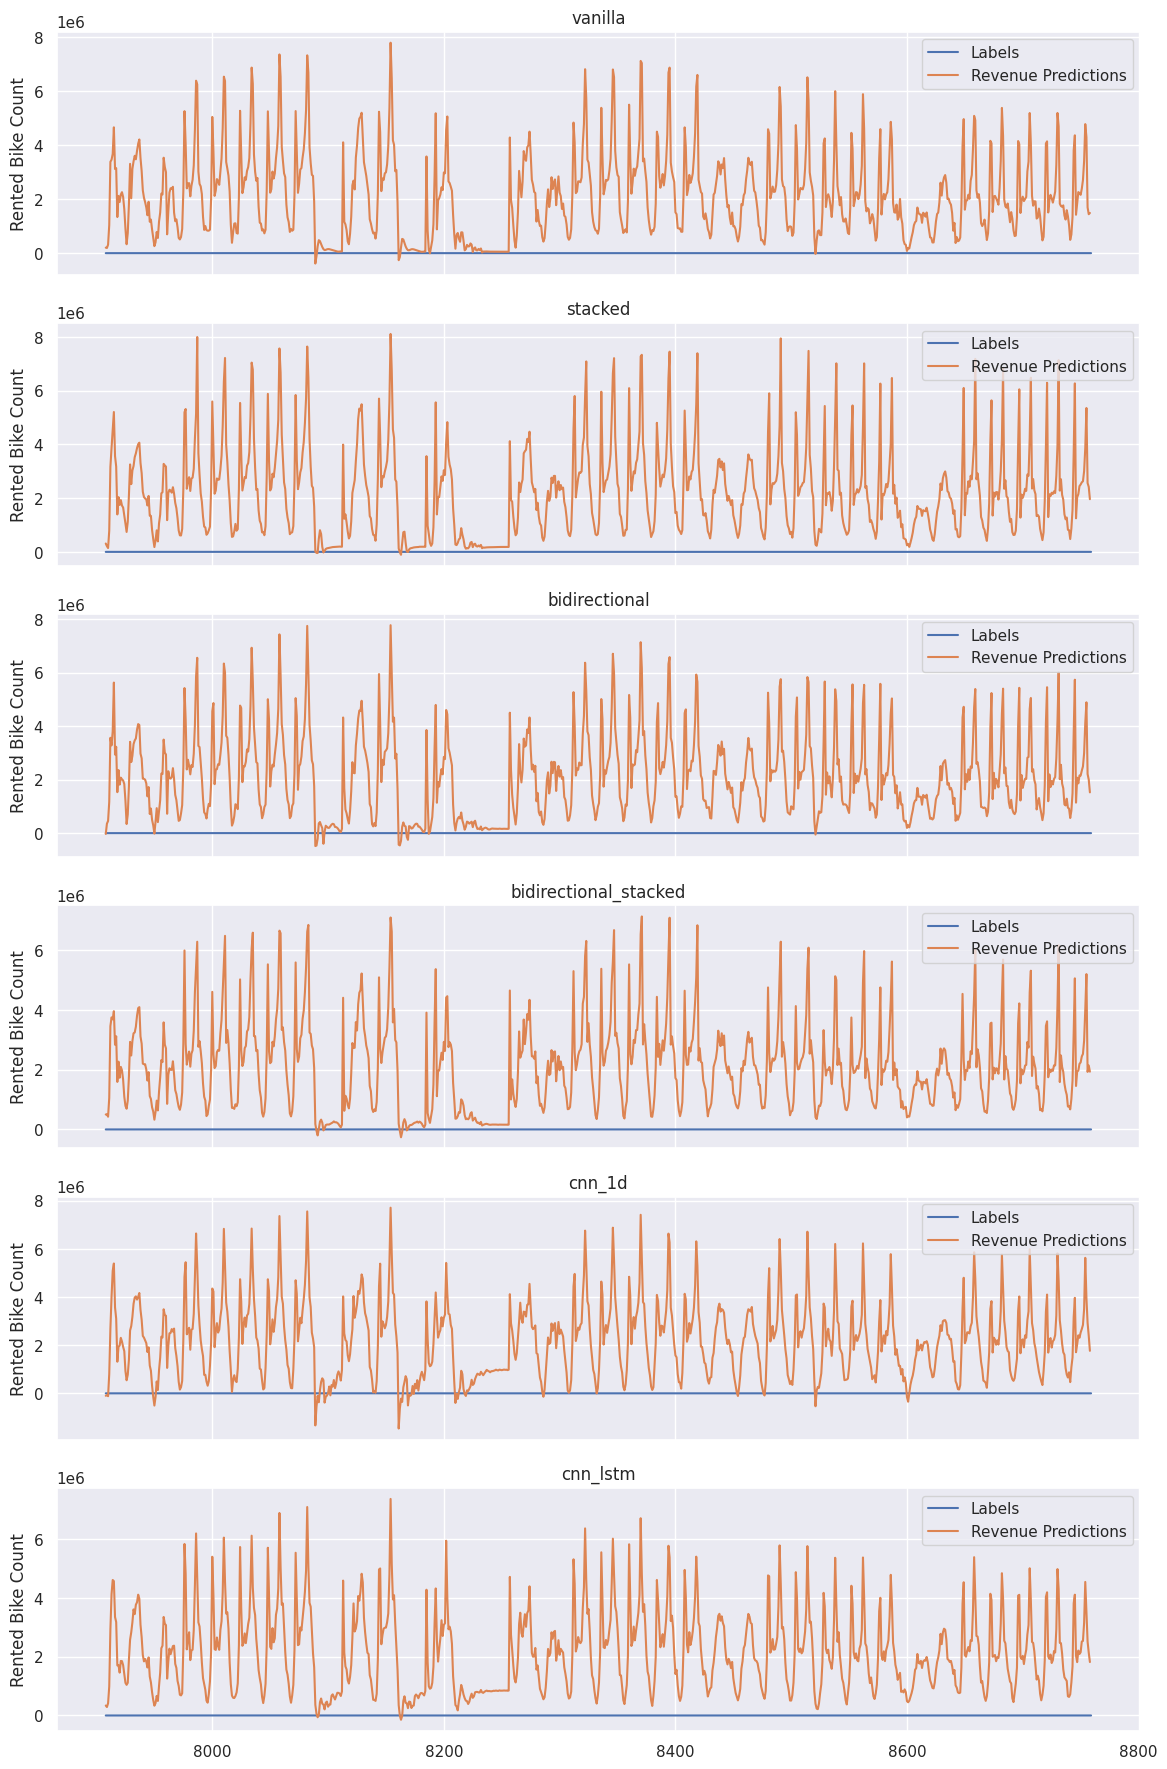

In [216]:

import pandas as pd
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(models), 1, figsize=(12, 3*len(models)), sharex=True)
fig.tight_layout(pad=2.0)

for index, (model_name, model) in enumerate(models.items()):
    # Use models to make predictions on the test set
    predictions = model.predict(single_step_window.test[0])
    predictions = pd.DataFrame(predictions, index=test_df.index[single_step_window.input_width:-1], columns=single_step_window.label_columns)

    # Denormalize the records to their actual values
    predictions_denormalized = denormalize(predictions, train_std, train_mean)
    test_df_denormalized = denormalize(test_df, train_std, train_mean)

    # Calculate revenue
    predictions_denormalized['Revenue'] = predictions_denormalized['Rented Bike Count'] * 3125

    # Plot the actual data, as well as the prediction data
    sns.lineplot(data=test_df_denormalized[24:], x=test_df_denormalized.index[24:], y='Rented Bike Count', label="Labels", ax=axes[index])
    sns.lineplot(data=predictions_denormalized, x=predictions_denormalized.index, y='Revenue', label="Revenue Predictions", ax=axes[index])
    axes[index].set_title(model_name)
    axes[index].set(xlabel=None)

plt.show()


In [235]:

import pandas as pd
# Use models to make predictions on the test set
predictions = lstm_stacked_bi.predict(single_step_window.test[0])
predictions = pd.DataFrame(predictions, index=test_df.index[single_step_window.input_width:-1], columns=single_step_window.label_columns)

# Denormalize the records to their actual values
predictions_denormalized = denormalize(predictions, train_std, train_mean)

# Calculate revenue
predictions_denormalized['Revenue'] = predictions_denormalized['Rented Bike Count'] * 3125

# Select the first 12 rows
revenue_predictions_12rows = predictions_denormalized[['Revenue']].head(12)
print(revenue_predictions_12rows)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
          Revenue
7908   499,359.53
7909   512,368.40
7910   425,100.36
7911 1,055,339.67
7912 3,455,299.24
7913 3,750,242.19
7914 3,683,496.13
7915 3,956,760.91
7916 2,835,533.57
7917 3,116,422.11
7918 1,590,152.46
7919 2,268,435.39


## Costos

In [246]:
# prompt: Ahora sacame los costos que se sacan con el promedio de uso de las bicicletas rentadas, entonces por cada 200 horas de uso en una bicicleta, se suman 60000 y el contador de esa bicicleta vuelve a 0

# Calculate the total hours of bike usage
total_hours = test_df_denormalized['Hour'].sum()

# Calculate the number of times the counter resets
reset_count = total_hours // 100

# Calculate the total cost
total_cost = reset_count * 60000

print(f"Total hours of bike usage: {total_hours}")
print(f"Number of times the counter resets: {reset_count}")
print(f"Total cost: {total_cost}")


Total hours of bike usage: 10146.0
Number of times the counter resets: 101.0
Total cost: 6060000.0


In [255]:


# Calculate the total revenue for the first 53 rows
total_revenue = revenue_predictions_12rows['Revenue'].sum()

# Calculate the profit
profit = total_revenue - total_cost

print(f"Total revenue for the first 53 rows: {total_revenue}")
print(f"Total cost: {total_cost}")
print(f"Profit: {profit}")


Total revenue for the first 53 rows: 27148509.96501064
Total cost: 6060000.0
Profit: 21088509.96501064


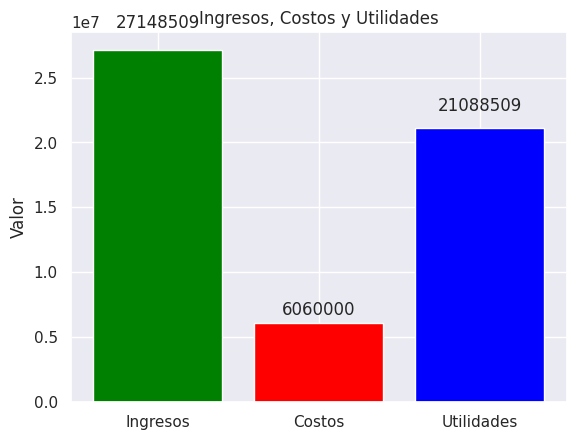

In [257]:

import matplotlib.pyplot as plt

# Data
total_revenue = revenue_predictions_12rows['Revenue'].sum()
total_cost = reset_count * 60000
profit = total_revenue - total_cost

# Create the plot
fig, ax = plt.subplots()
bars = ax.bar(['Ingresos', 'Costos', 'Utilidades'], [total_revenue, total_cost, profit], color=['green', 'red', 'blue'])

# Add labels to the bars
for bar in bars:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width()/2., 1.05*height,
          '%d' % int(height),
          ha='center', va='bottom')

# Set title and labels
ax.set_title('Ingresos, Costos y Utilidades')
ax.set_ylabel('Valor')

# Show the plot
plt.show()


### Ajuste del Modelo

El ajuste de hiperparámetros es un paso esencial en la construcción de modelos de aprendizaje automático. Implica seleccionar el conjunto adecuado de hiperparámetros para tu modelo, lo cual puede ser un proceso largo y tedioso. KerasTuner simplifica este proceso al automatizar la búsqueda de hiperparámetros óptimos, ahorrando así tiempo y esfuerzo.

Para este propósito, voy a seleccionar la arquitectura de LSTM apilado para el ajuste fino.

In [152]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(n_steps, n_features)))

    # Tune number of units
    model.add(LSTM(units=hp.Int("lstm1_units", min_value=24, max_value=64, step=8), return_sequences=True))
    model.add(LSTM(units=hp.Int("lstm2_units", min_value=24, max_value=64, step=8)))

    # Tune whether to use a intermediate dense layer.
    if hp.Boolean("dense_layer"):
        model.add(Dense(units=hp.Int("dense_units", min_value=24, max_value=32, step=8), activation="relu"))

    model.add(Dense(n_outputs, activation='linear'))

    model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = MeanSquaredError(),
                  metrics = [MeanAbsoluteError()])
    return model

### Keras Tuner

Un afinador de Keras llamado BayesianOptimization, es una técnica utilizada para optimizar funciones de caja negra que son costosas de evaluar. La idea principal detrás de la optimización bayesiana es equilibrar la exploración y la explotación, con el fin de encontrar el óptimo global de la función con la menor cantidad de evaluaciones posible.

In [153]:
tuner = kt.BayesianOptimization(model_builder,
                                objective='val_loss',
                                max_trials=4,
                                directory='keras_tuner',
                                project_name='stacked_lstm')

In [154]:
tuner_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                  start_from_epoch=5)

In [155]:
tuner.search(single_step_window.train[0], single_step_window.train[1], epochs=epocas,
             validation_data=single_step_window.val, callbacks=[tuner_stopping])

Trial 4 Complete [00h 01m 53s]
val_loss: 0.08223473280668259

Best val_loss So Far: 0.06445582956075668
Total elapsed time: 00h 12m 01s


In [156]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 24, 64)              │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 24)                  │           8,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,321 (102.82 KB)

 Trainable params: 26,321 (102.82 KB)

 Non-trainable params: 0 (0.00 B)

Re-entrenamiento

In [157]:
hypermodel.fit(single_step_window.train[0], single_step_window.train[1],
               validation_data=single_step_window.val,
               epochs=epocas,
               callbacks=[tuner_stopping])

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.5614 - mean_absolute_error: 0.5329 - val_loss: 0.2896 - val_mean_absolute_error: 0.3854
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1776 - mean_absolute_error: 0.2722 - val_loss: 0.1441 - val_mean_absolute_error: 0.2618
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.1065 - mean_absolute_error: 0.1999 - val_loss: 0.1281 - val_mean_absolute_error: 0.2411
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0921 - mean_absolute_error: 0.1849 - val_loss: 0.1142 - val_mean_absolute_error: 0.2252
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0787 - mean_absolute_error: 0.1718 - val_loss: 0.1050 - val_mean_absolute_error: 0.2156
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0676 - mean_absolute_error: 0.1603 - val_loss: 0.1019 - val_mean_absolute_error: 0.2150
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0613 - mean_absolute_error: 0

Evaluacion

In [158]:
eval_result = hypermodel.evaluate(single_step_window.test[0], single_step_window.test[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1205 - mean_absolute_error: 0.2160


Mejoramiento

In [159]:
def percentage(start, final):
    change = round(((final-start)/start)*100,3)
    if change >= 0:
        return f"{abs(change)}% worse"
    else:
        return f"{abs(change)}% better"

old_performance = performance['stacked']

print("\n".join([f"Test loss: {round(eval_result[0],5)} from {round(old_performance[0],5)} ({percentage(old_performance[0], eval_result[0])})",
                 f"Test MAE:  {round(eval_result[1],5)} from {round(old_performance[1],5)} ({percentage(old_performance[1], eval_result[1])})"]))

Test loss: 0.12735 from 0.13481 (5.533% better)
Test MAE:  0.22109 from 0.20328 (8.762% worse)


Predicciones

In [160]:
def get_sin_cos_timestamp(timestamp):

    date_time = pd.to_datetime(timestamp, format='%Y.%m.%d %H:%M:%S')
    timestamp = pd.Timestamp.timestamp(date_time)

    return [np.sin(timestamp * (2 * np.pi / day)),
            np.cos(timestamp * (2 * np.pi / day)),
            np.sin(timestamp * (2 * np.pi / year)),
            np.cos(timestamp * (2 * np.pi / year))]

In [161]:
def auto_predict(model, window, date_range):


    X_future = deepcopy(window.test[0][-1:])
    y_future = []

    index = 0

    for target_date in date_range:
        # Make new prediction
        prediction = model.predict(X_future[-1:], verbose=None)
        y_future.append(prediction)

        # Create new input
        input = X_future[-1][1:]
        num_features = window.train[1].shape[-1]
        timestamp_sin_cos = get_sin_cos_timestamp(target_date)
        timestamp_sin_cos = (timestamp_sin_cos - train_mean[window.train_df.columns][num_features:]) / train_std[window.train_df.columns][num_features:]

        observation = np.concatenate((prediction[0], timestamp_sin_cos), axis=0)
        observation = np.expand_dims(observation, axis=0)

        input = np.concatenate((input, observation), axis=0)
        input = np.expand_dims(input, axis=0)

        X_future = np.concatenate((X_future, input), axis=0)

        print(f"{index+1}/{len(date_range)}", end='\r', flush=True)

        index += 1

    return np.array(y_future)

In [199]:
future_dates = pd.date_range(start='1994-01-01', end='1995-02-01', freq='1H')

In [200]:

import numpy as np
import pandas as pd


def get_sin_cos_timestamp(timestamp):

    day = 24*60*60
    year = 365.2425 * day

    date_time = pd.to_datetime(timestamp, format='%Y.%m.%d %H:%M:%S')
    timestamp = pd.Timestamp.timestamp(date_time)

    return [np.sin(timestamp * (2 * np.pi / day)),
            np.cos(timestamp * (2 * np.pi / day)),
            np.sin(timestamp * (2 * np.pi / year)),
            np.cos(timestamp * (2 * np.pi / year))]

In [201]:
def auto_predict(model, window, date_range):


    X_future = deepcopy(window.test[0][-1:])
    y_future = []

    index = 0

    for target_date in date_range:
        # Make new prediction
        prediction = model.predict(X_future[-1:], verbose=None)
        y_future.append(prediction)

        # Create new input
        input = X_future[-1][1:]
        num_features = window.train[1].shape[-1]
        timestamp_sin_cos = get_sin_cos_timestamp(target_date)
        # The following line is changed to select the last four values of train_mean and train_std
        timestamp_sin_cos = (np.array(timestamp_sin_cos) - train_mean[window.train_df.columns][-4:]) / train_std[window.train_df.columns][-4:]

        observation = np.concatenate((prediction[0], timestamp_sin_cos), axis=0)
        observation = np.expand_dims(observation, axis=0)

        input = np.concatenate((input, observation), axis=0)
        input = np.expand_dims(input, axis=0)

        X_future = np.concatenate((X_future, input), axis=0)

        print(f"{index+1}/{len(date_range)}", end='\r', flush=True)

        index += 1

    return np.array(y_future)

In [202]:
future_df = pd.DataFrame(predictions[:len(predictions)].values.flatten(), index = future_dates[:len(predictions)], columns =['Future Prediction'])
# Sliced future_dates to match the length of predictions, ensuring matching shapes for the DataFrame.

In [203]:
def plot_predictions(model, window, future_predictions=None, symetric=False, title='Predictions'):
    # Get test set predictions.
    test_predictions = model.predict(window.test[0])
    test_predictions = pd.DataFrame(test_predictions, index=window.test_df.index[window.input_width:-1], columns=window.label_columns)

    # Set figure properties.
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    ax.set_title(title)

    # Show the same amount of testing timesteps as future timesteps.
    if symetric == True:
        start_index = -len(future_predictions)
        sns.lineplot(data=window.test_df[start_index:], x=window.test_df.index[start_index:], y=window.label_columns[0], label="Test Data")
        sns.lineplot(data=test_predictions[start_index:], x=test_predictions.index[start_index:], y=window.label_columns[0], label="Test Prediction")
    else:
        sns.lineplot(data=window.test_df, x=window.test_df.index, y=window.label_columns[0], label="Test Data")
        sns.lineplot(data=test_predictions, x=test_predictions.index, y=window.label_columns[0], label="Test Prediction")

    sns.lineplot(data=future_predictions, x=future_predictions.index, y=future_predictions['Future Prediction'], label="Future Prediction")
    ax.set(xlabel=None)
    plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


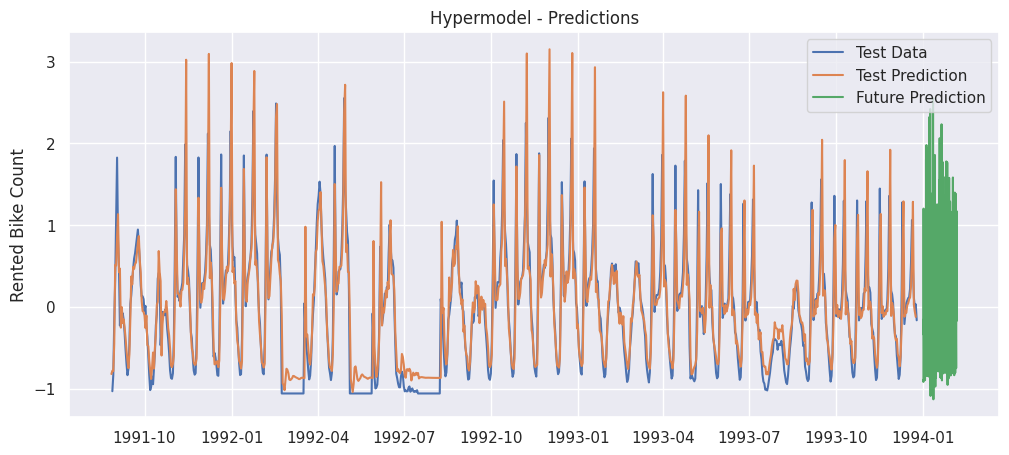

In [206]:
plot_predictions(hypermodel, single_step_window, future_df, symetric=True, title='Hypermodel - Predictions')

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


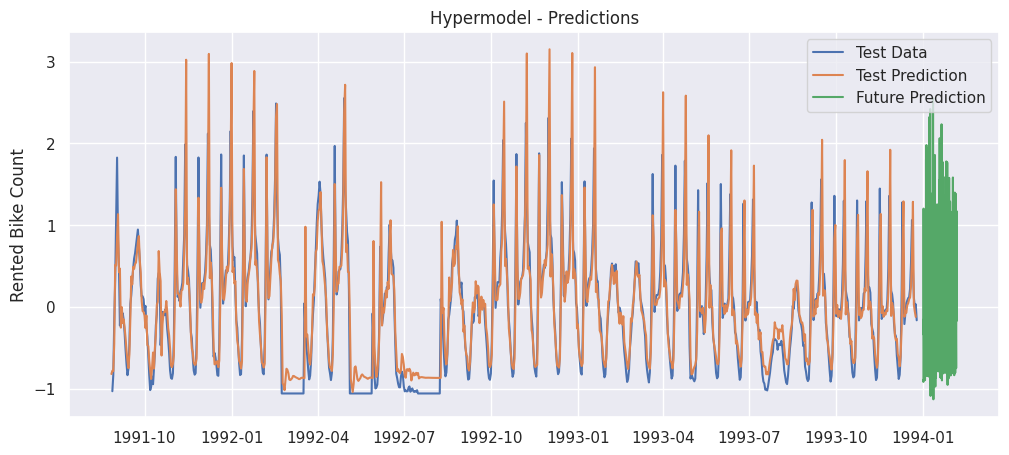

In [207]:
# prompt: mis datos de Future Predictions estan muy unidos y no se distingen de los demas, imprimeme el grafico de predicciones tambien

import pandas as pd
import matplotlib.pyplot as plt
def plot_predictions(model, window, future_predictions=None, symetric=False, title='Predictions'):
    # Get test set predictions.
    test_predictions = model.predict(window.test[0])
    test_predictions = pd.DataFrame(test_predictions, index=window.test_df.index[window.input_width:-1], columns=window.label_columns)

    # Set figure properties.
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    ax.set_title(title)

    # Show the same amount of testing timesteps as future timesteps.
    if symetric == True:
        start_index = -len(future_predictions)
        sns.lineplot(data=window.test_df[start_index:], x=window.test_df.index[start_index:], y=window.label_columns[0], label="Test Data")
        sns.lineplot(data=test_predictions[start_index:], x=test_predictions.index[start_index:], y=window.label_columns[0], label="Test Prediction")
    else:
        sns.lineplot(data=window.test_df, x=window.test_df.index, y=window.label_columns[0], label="Test Data")
        sns.lineplot(data=test_predictions, x=test_predictions.index, y=window.label_columns[0], label="Test Prediction")

    sns.lineplot(data=future_predictions, x=future_predictions.index, y=future_predictions['Future Prediction'], label="Future Prediction")
    ax.set(xlabel=None)
    plt.show()
plot_predictions(hypermodel, single_step_window, future_df, symetric=True, title='Hypermodel - Predictions')
